In [20]:
# === 1. 准备数据: 加载 npy 文件并整理为 [N, 45] ===
import numpy as np
import torch
import shap
import matplotlib.pyplot as plt
import torch.nn as nn

In [21]:
data = np.load("dataset_first.npy", allow_pickle=True)

In [22]:
all_cells_flattened = []
for group in data:
    for cell in group:
        feat_part1 = cell[0].flatten()  # (6,5) → 30维
        feat_part2 = cell[1]            # (15,)
        full_feat = np.concatenate([feat_part1, feat_part2])
        all_cells_flattened.append(full_feat)

In [23]:
cell_features = np.stack(all_cells_flattened)  # shape: [48, 45]


In [24]:
class SetNetClassifier(nn.Module):
    def __init__(self, input_dim=45*8, hidden_dim=128, classifier_hidden=128, output_dim=3):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, classifier_hidden),
            nn.ReLU(),
            nn.Linear(classifier_hidden, output_dim)
        )
    
    def forward(self, x):
        return self.classifier(x)

In [25]:

# === 2. 加载训练好的模型 ===
model = SetNetClassifier()
state_dict = torch.load("model.pt", map_location=torch.device('cpu'))  # ← 文件名改成你保存的
model.load_state_dict(state_dict)
model.eval()

SetNetClassifier(
  (classifier): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [26]:
# === 3. 包装模型用于 SHAP ===
def wrapped_model(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32)
    with torch.no_grad():
        logits = model(x_tensor)
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.numpy()


In [27]:
group_features = []
for group in data:
    cell_features = []
    for cell in group:
        feat1 = cell[0].flatten()  # 6×5 → 30
        feat2 = cell[1]            # 15
        cell_feat = np.concatenate([feat1, feat2])  # 45维
        cell_features.append(cell_feat)
    
    group_feat = np.concatenate(cell_features)  # 8个细胞拼成 [360]
    group_features.append(group_feat)

X = np.stack(group_features)  # [6, 360]

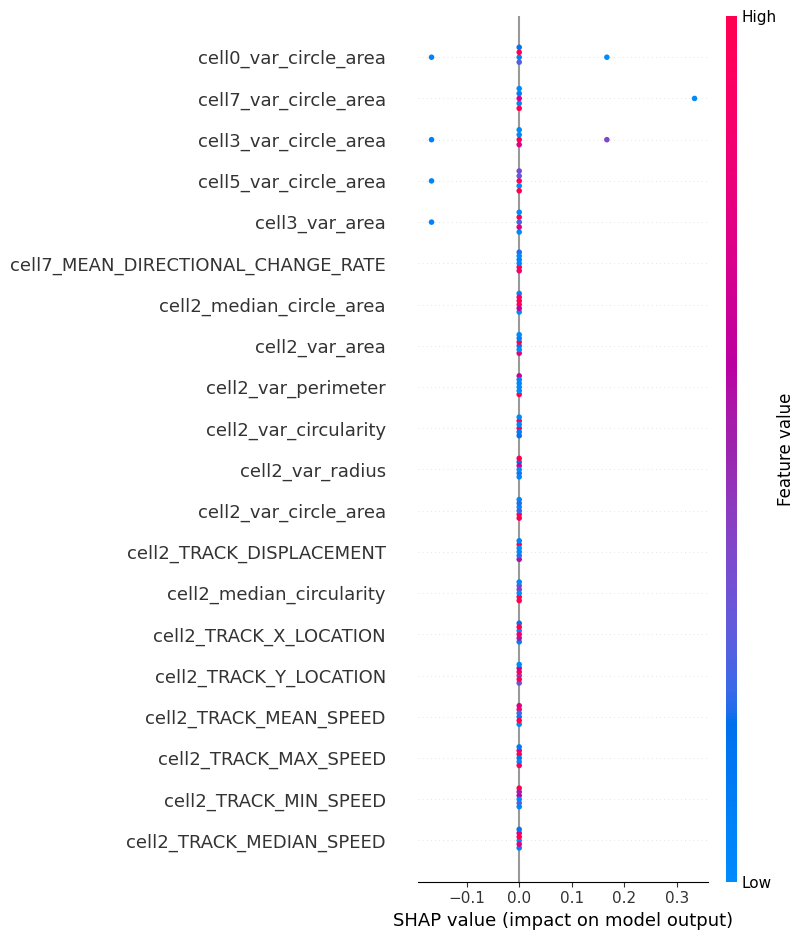

In [ ]:
explainer = shap.Explainer(wrapped_model, masker=X[:3], algorithm="permutation")
shap_values = explainer(X, max_evals=1000)

# 可视化（细胞维度解释）
feature_labels = []
for i in range(8):
    feature_labels.extend([
        f"cell{i}_{stat}_{attr}" for stat in ['mean', 'std', 'min', 'max', 'median', 'var']
        for attr in ['area', 'perimeter', 'circularity', 'radius', 'circle_area']
    ] + [
        f"cell{i}_{k}" for k in [
            "TRACK_DISPLACEMENT", "TRACK_X_LOCATION", "TRACK_Y_LOCATION", "TRACK_MEAN_SPEED",
            "TRACK_MAX_SPEED", "TRACK_MIN_SPEED", "TRACK_MEDIAN_SPEED", "TRACK_STD_SPEED",
            "TRACK_MEAN_QUALITY", "TOTAL_DISTANCE_TRAVELED", "MAX_DISTANCE_TRAVELED",
            "CONFINEMENT_RATIO", "MEAN_STRAIGHT_LINE_SPEED", "LINEARITY_OF_FORWARD_PROGRESSION",
            "MEAN_DIRECTIONAL_CHANGE_RATE"
        ]
    ])
feature_labels = np.array(feature_labels)
shap.summary_plot(shap_values.values[:, :, 0], features=X, feature_names=feature_labels)

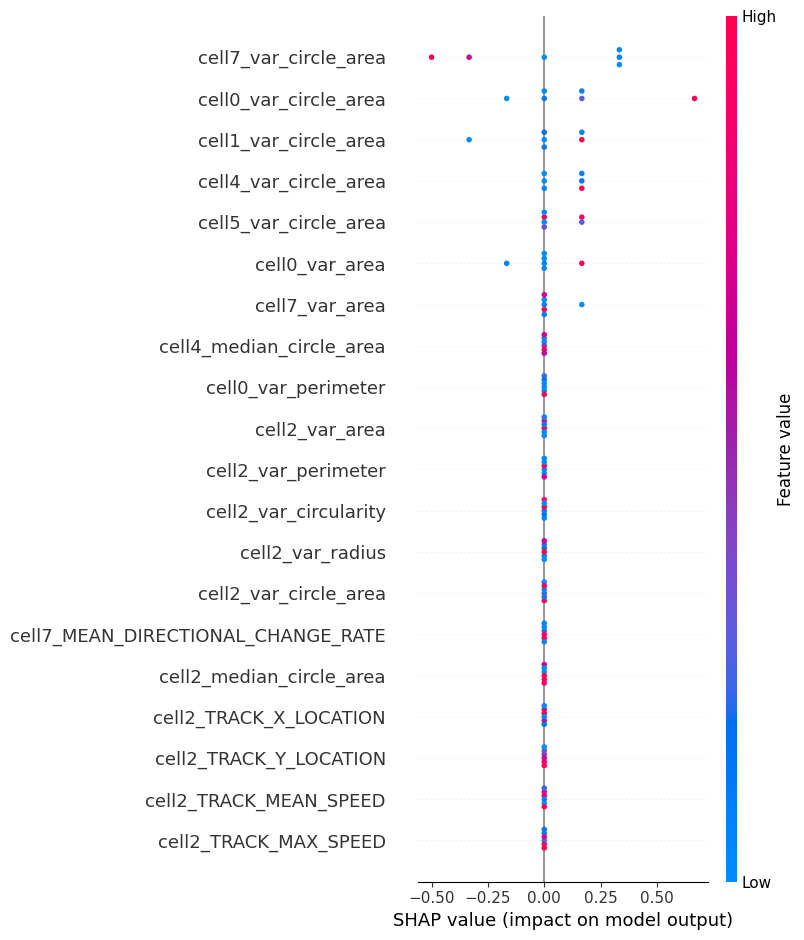

In [37]:
shap.summary_plot(shap_values.values[:, :, 1], features=X, feature_names=feature_labels)

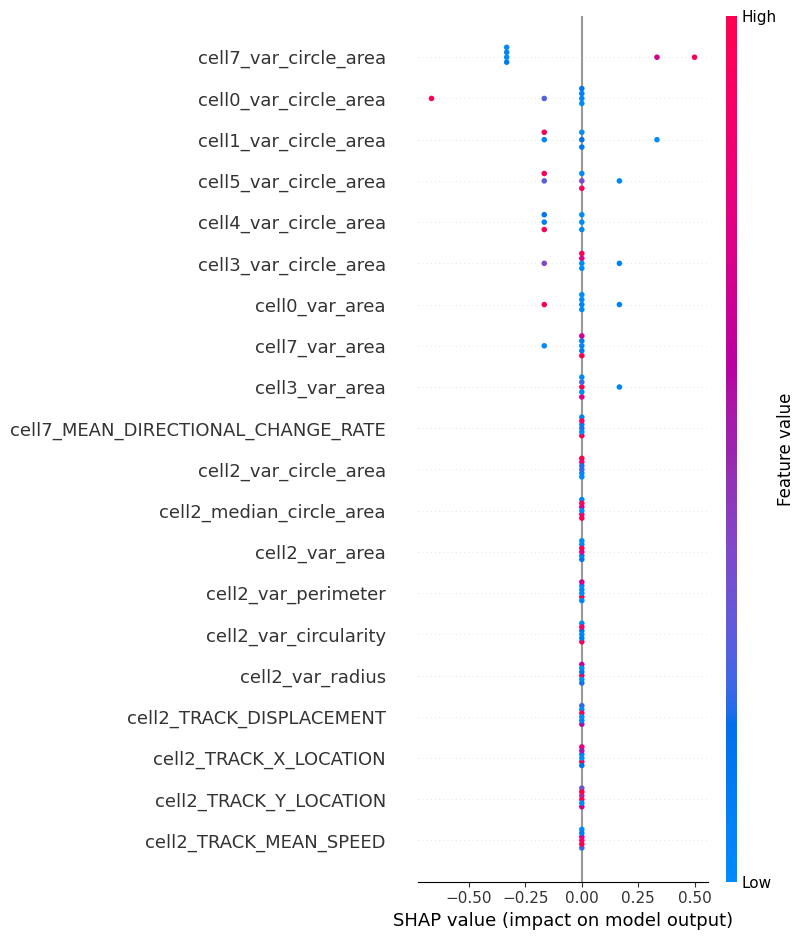

In [36]:
shap.summary_plot(shap_values.values[:, :, 2], features=X, feature_names=feature_labels)

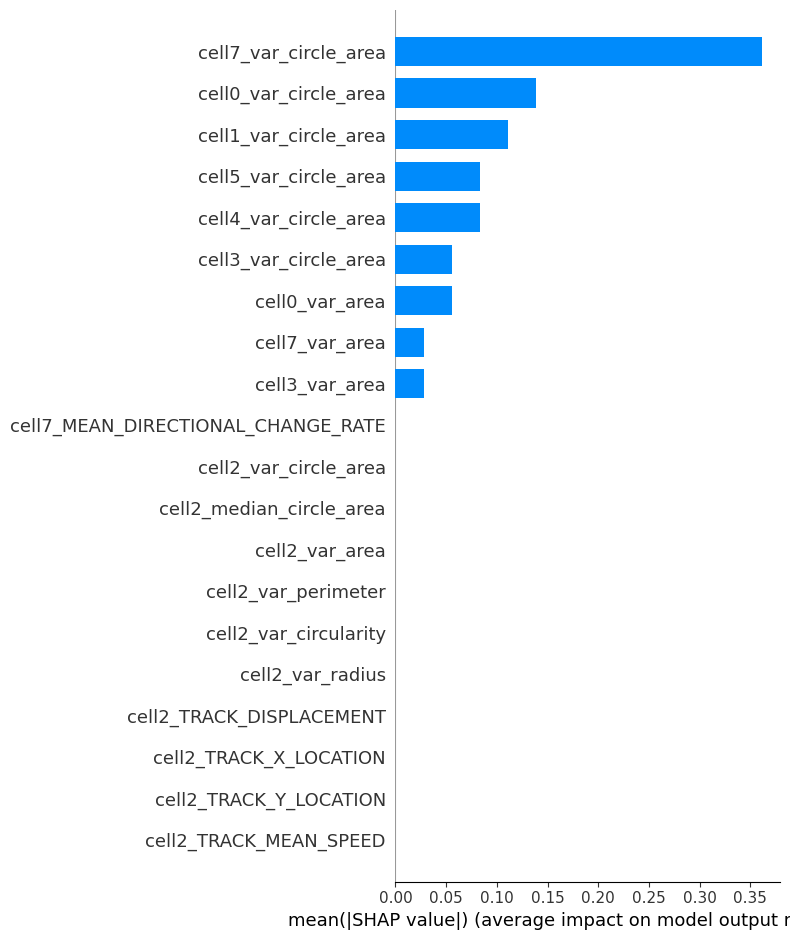

In [39]:
shap.summary_plot(
    shap_values.values[:, :, 2],
    features=X,
    feature_names=feature_labels,
    plot_type="bar",
    max_display=20
)

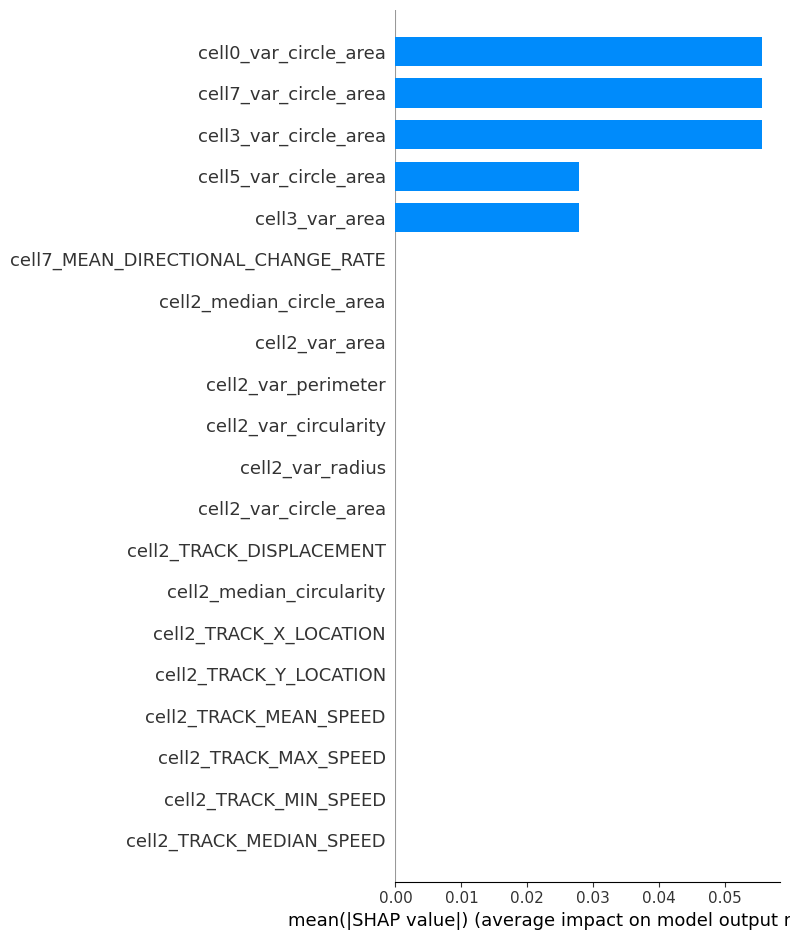

In [40]:
shap.summary_plot(
    shap_values.values[:, :, 0],
    features=X,
    feature_names=feature_labels,
    plot_type="bar",
    max_display=20
)

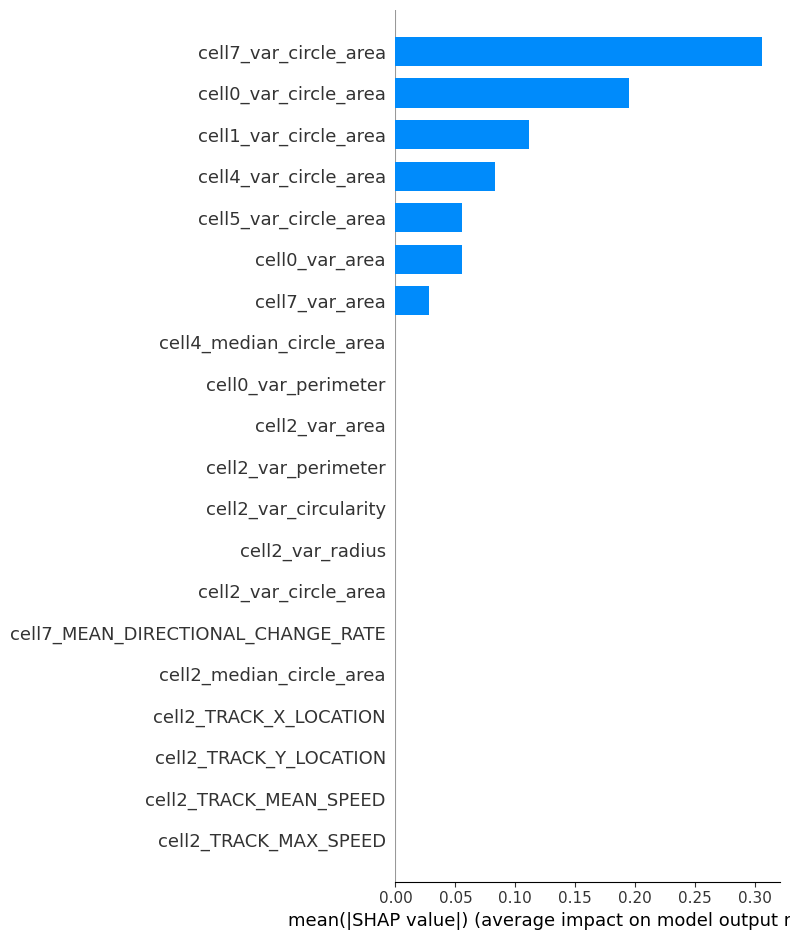

In [41]:
shap.summary_plot(
    shap_values.values[:, :, 1],
    features=X,
    feature_names=feature_labels,
    plot_type="bar",
    max_display=20
)